## Vehicle Detection Project
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import numpy.random
import random

from skimage.feature import hog
import pickle
import os


from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

%matplotlib inline

### Reading and display images

Images have been loaded
Not Cars:  8968
Cars:  8792


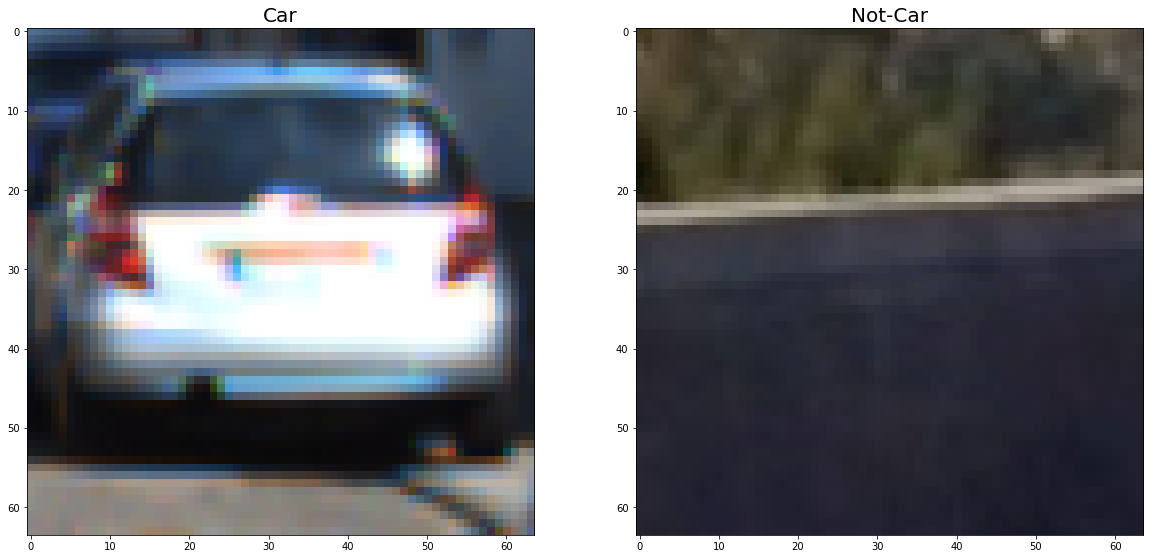

In [2]:
vehicles_paths = glob.glob('train_images/vehicles/**/*.png')
non_vehicles_paths = glob.glob('train_images/non-vehicles/**/*.png')
cars = []
not_cars = []


for image in vehicles_paths:
    cars.append(mpimg.imread(image))
for image in non_vehicles_paths:
    not_cars.append(mpimg.imread(image))

print('Images have been loaded')
print('Not Cars: ', len(not_cars))
print('Cars: ', len(cars))

sample_car = random.choice(cars)
sample_notcar = random.choice(not_cars)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(sample_car)
ax2.imshow(sample_notcar)
ax1.set_title('Car', fontsize=20)
ax2.set_title('Not-Car', fontsize=20)

plt.savefig('examples/original_data.png')

### Histogram of Oriented Gradients (HOG) feature extraction 

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, transform_sqrt=True,feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block),  visualise=False, transform_sqrt=True,feature_vector=feature_vec)
        return features

/Users/wmh/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


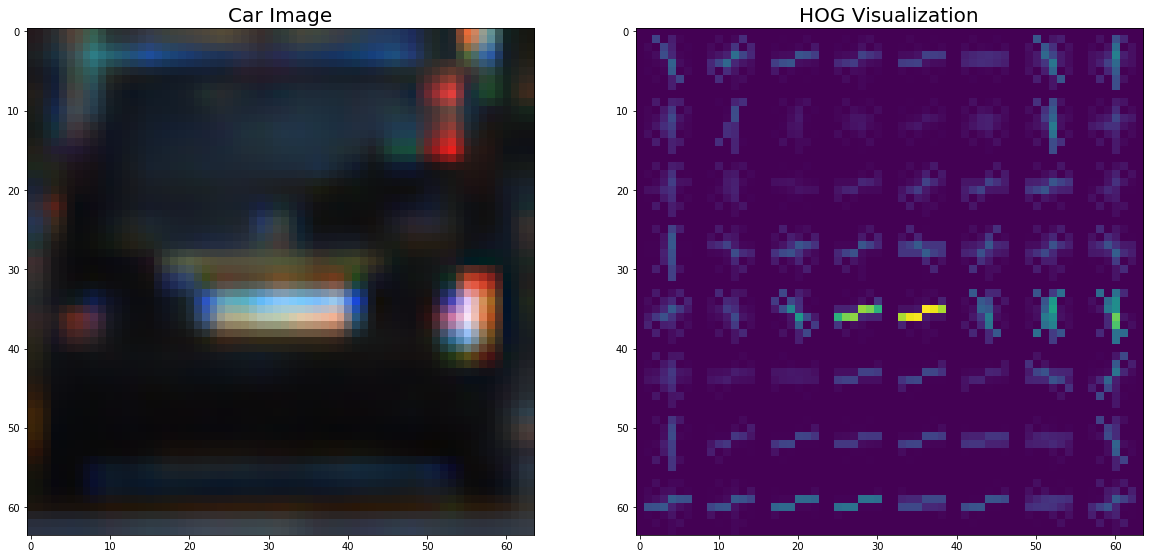

In [4]:
# test get_hog_features function
index = np.random.randint(0, len(cars))
image = cars[index]
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)


# Plot the examples
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax2.imshow(hog_image)
ax1.set_title('Car Image', fontsize=20)
ax2.set_title('HOG Visualization', fontsize=20)


plt.savefig('examples/hog_visualization_features.png')

## Extract binded color features and histograms of color

In [5]:
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features

def color_hist(img, nbins=32):
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

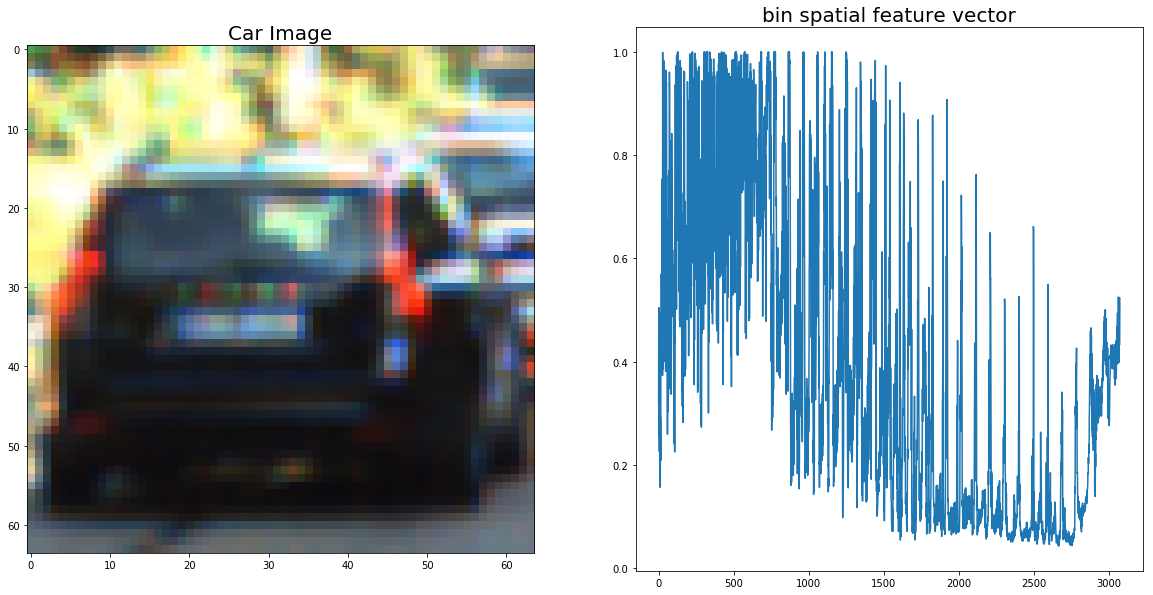

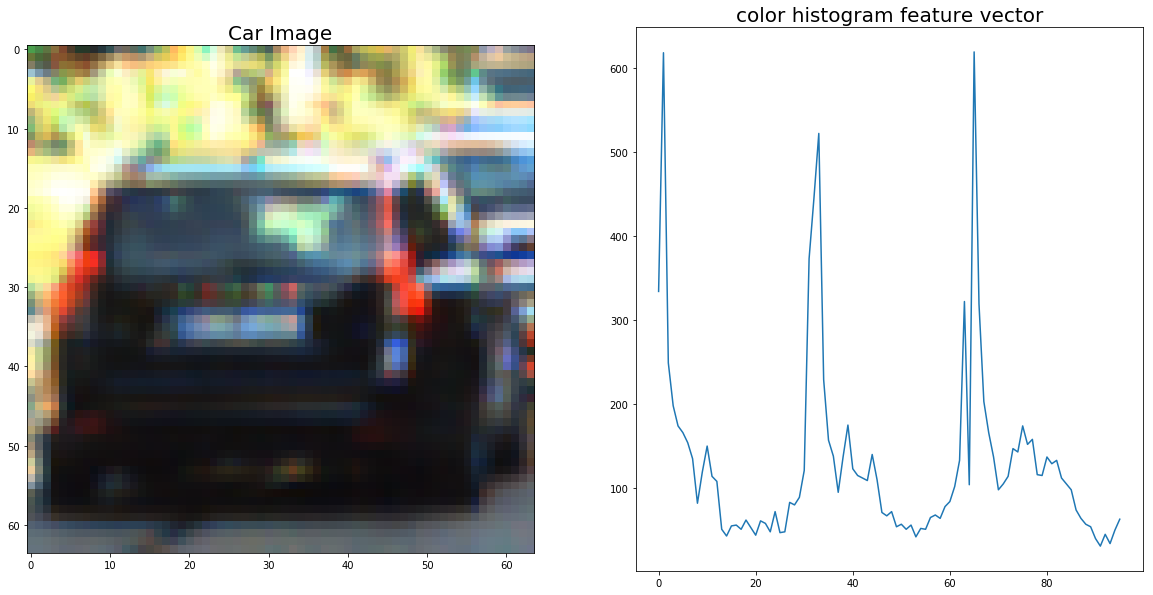

In [6]:
# test functions
index = np.random.randint(0, len(cars))
image = cars[index]

spatial_features = bin_spatial(image)
xVec = np.vstack((spatial_features)).astype(np.float64)  

hist_features = color_hist(image)
yVec = np.vstack((hist_features)).astype(np.float64)  


fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Car Image',fontsize=20)
plt.subplot(122)
plt.plot(xVec)
plt.title('bin spatial feature vector',fontsize=20)
plt.savefig('examples/bin_spatial_features.png')

fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Car Image',fontsize=20)
plt.subplot(122)
plt.plot(yVec)
plt.title('color histogram feature vector',fontsize=20)
plt.savefig('examples/color_histogram_featuress.png')


### Define some functions 

In [7]:
# Define a function to call bin_spatial() and color_hist() so as to extract features from a list of images 
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features


# Define a function that takes an image, start and stop positions in both x and y,
# window size (x and y dimensions), and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # 1) Define an empty list to receive features
    img_features = []
    # 2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    # 3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # 4) Append features to list
        img_features.append(spatial_features)
    # 5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # 6) Append features to list
        img_features.append(hist_features)
    # 7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # 8) Append features to list
        img_features.append(hog_features)

    # 9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.append(window)
    return on_windows

### The feature super-parameters

In [45]:
y_start_stop = [336, 700] # Min and max in y to search in slide_window()
color_space = 'YCrCb' #  RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 12 # HOG pixels per cellhog_channel = 'ALL' #  0, 1, 2, or "ALL"
hist_bins = 32    # Number of histogram bins
cell_per_block = 2 # HOG cells per block
spatial_size = (32, 32) # Spatial binning dimensions
hog_channel = 'ALL' #  0, 1, 2, or "ALL"
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
vis = True

### Training Classifier

In [9]:
car_features = extract_features(cars, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(not_cars, color_space=color_space,
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel, spatial_feat=spatial_feat,
                                   hist_feat=hist_feat, hog_feat=hog_feat)


X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell,
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()

# Save classifier
clf_file = "svc_classifier_pickle.p"
print("Saving classifier, scaler and parameters into file: ", clf_file)

dist_pickle = {}
dist_pickle["svc"]= svc
dist_pickle["color_space"]= color_space
dist_pickle["scaler"]= X_scaler
dist_pickle["orient"]= orient
dist_pickle["pix_per_cell"]= pix_per_cell
dist_pickle["cell_per_block"]=cell_per_block
dist_pickle["spatial_size"]=spatial_size
dist_pickle["hist_bins"]= hist_bins
dist_pickle["hog_channel"]= hog_channel
dist_pickle["spatial_feat"]= spatial_feat
dist_pickle["hist_feat"]= hist_feat
dist_pickle["hog_feat"]= hog_feat


pickle.dump(dist_pickle,  open(clf_file, 'wb'))

/Users/wmh/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 12 pixels per cell and 2 cells per block
Feature vector length: 4896
9.53 Seconds to train SVC...
Test Accuracy of SVC =  0.989
Saving classifier, scaler and parameters into file:  svc_classifier_pickle.p


### define heatmap related functions

In [47]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img

def multi_slide_windows(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(64, 64), xy_overlap=(0.75, 0.75)):
    windows = []
    for size in [ 96, 140]:
        window = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=(size, size), xy_overlap=xy_overlap)
        windows += window
    return windows

### Test functions with a image

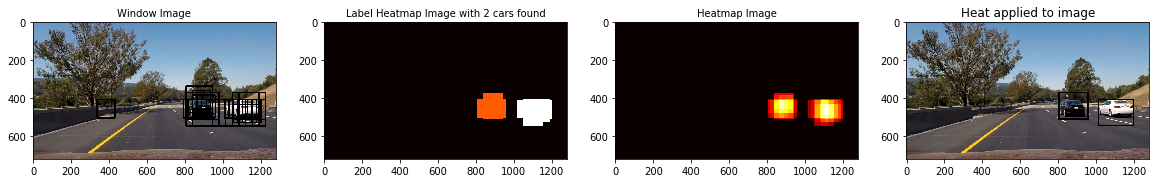

In [16]:
image = mpimg.imread('./test_images/test6.jpg')
image = image.astype(np.float32)/255
draw_image = np.copy(image)
heat_threshold = 2


windows = multi_slide_windows(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_overlap=(0.75, 0.75))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                         spatial_size=spatial_size, hist_bins=hist_bins,
                         orient=orient, pix_per_cell=pix_per_cell,
                         cell_per_block=cell_per_block,
                         hog_channel=hog_channel, spatial_feat=spatial_feat,
                         hist_feat=hist_feat, hog_feat=hog_feat)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
heat = np.zeros_like(window_img[:,:,0]).astype(np.float)

heatmap = add_heat(heat, hot_windows)
heatmap = apply_threshold(heatmap, heat_threshold)

labels = label(heatmap)
applied_image = draw_labeled_bboxes(draw_image, labels)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
ax1.imshow(window_img)
ax1.set_title('Window Image', fontsize=10)

ax2.imshow(labels[0], cmap='hot')
ax2.set_title('Label Heatmap Image with {} cars found'.format(labels[1]), fontsize=10)

ax3.imshow(heatmap, cmap='hot')
ax3.set_title('Heatmap Image', fontsize=10)

ax4.imshow(applied_image)
ax4.set_title('Heat applied to image')
    

### Pipeline

In [88]:
heat_threshold = 1

def process_image(img):

    image = img.astype(np.float32)/255
    draw_image = np.copy(image)
    #windows = multi_slide_windows(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_overlap=(0.75, 0.75))
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(80, 88), xy_overlap=(0.75, 0.75))
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                             spatial_size=spatial_size, hist_bins=hist_bins,
                             orient=orient, pix_per_cell=pix_per_cell,
                             cell_per_block=cell_per_block,
                             hog_channel=hog_channel, spatial_feat=spatial_feat,
                             hist_feat=hist_feat, hog_feat=hog_feat)

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    heat = np.zeros_like(window_img[:,:,0]).astype(np.float)
    heatmap = add_heat(heat, hot_windows)
    heatmap = apply_threshold(heatmap, heat_threshold)
    labels = label(heatmap)
    applied_image = draw_labeled_bboxes(np.copy(img), labels) 
    
    return applied_image

### process test images

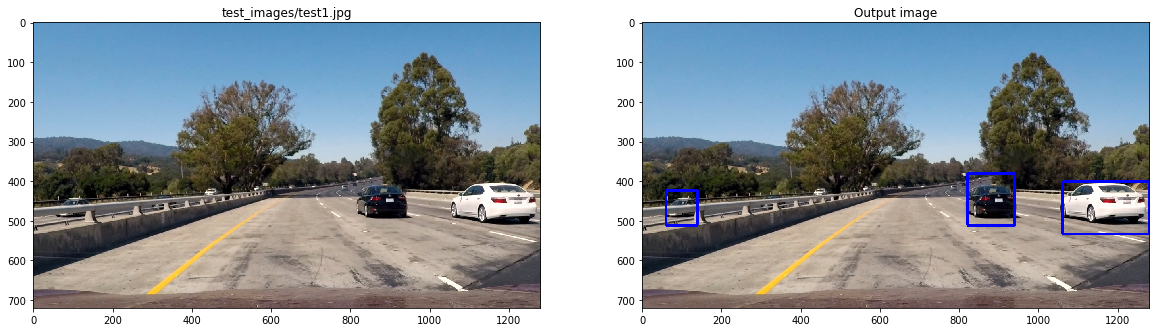

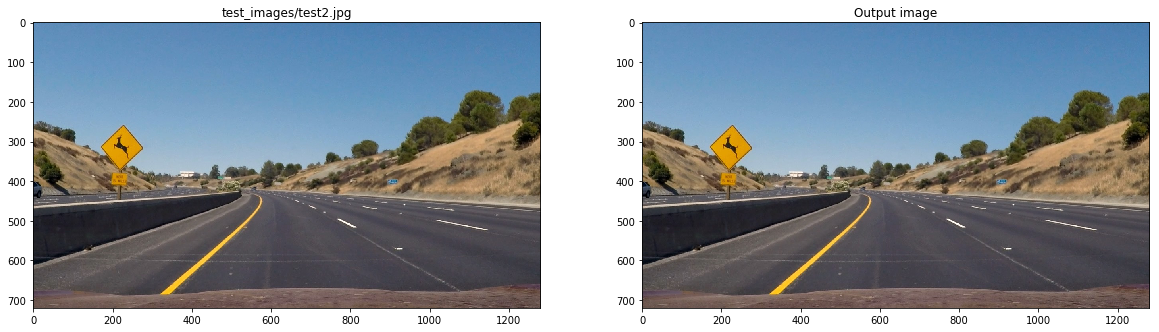

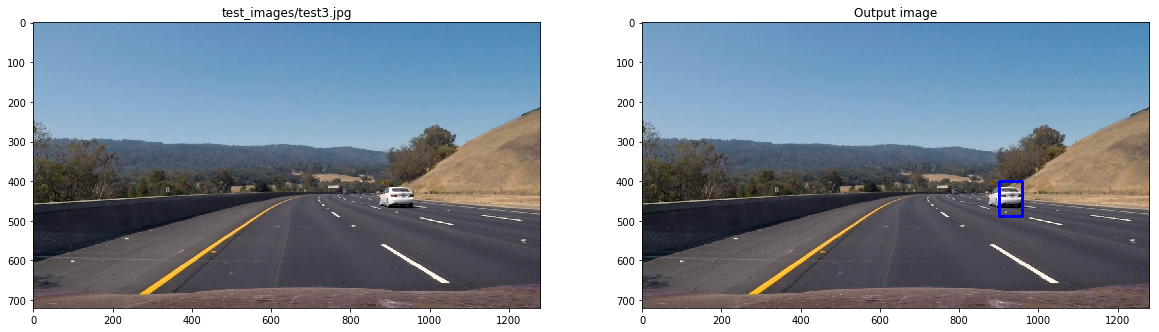

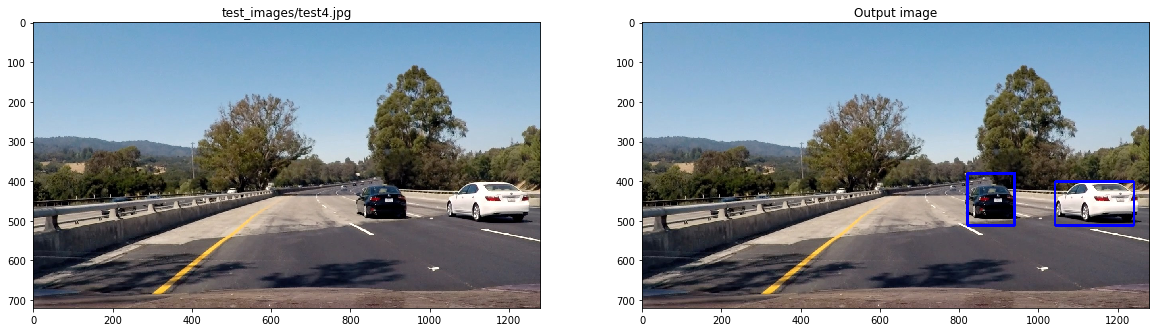

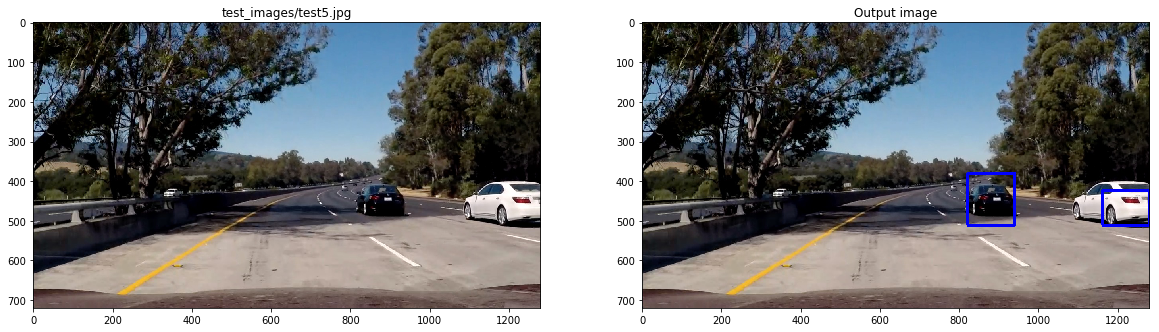

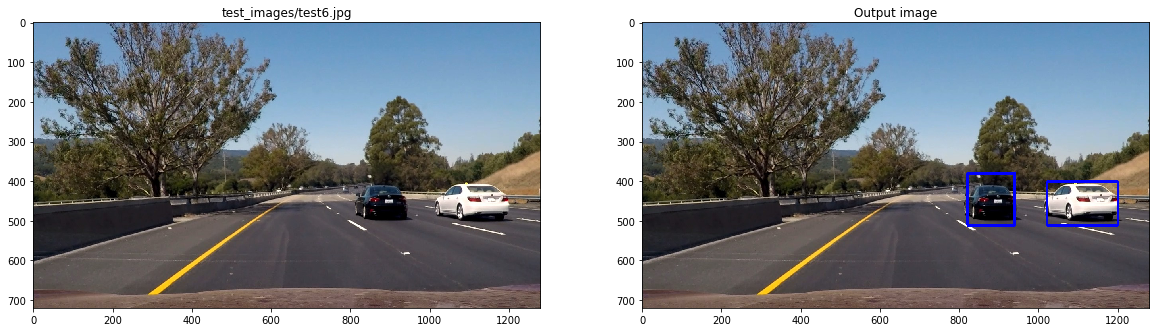

In [89]:
for filename in glob.glob("test_images/*.jpg"):
    orig_filename, _ = os.path.splitext(filename)
    orig_filename = orig_filename.replace('test_images/', '')
    
    img = mpimg.imread(filename)
    app_image = process_image(img)
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.imshow(img)
    plt.title(filename)
    plt.subplot(122)
    plt.imshow(app_image)
    plt.title('Output image')
    fig.tight_layout()
    
    
    plt.savefig('output_images/' + orig_filename + '.png')

### process video

In [90]:
# Process video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

movie_output = 'processed_project_video.mp4'
clip1 = VideoFileClip("./project_video.mp4", audio=False)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(movie_output, audio = False)

[MoviePy] >>>> Building video processed_project_video.mp4
[MoviePy] Writing video processed_project_video.mp4



100%|█████████▉| 1260/1261 [58:41<00:02,  2.81s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_project_video.mp4 



In [91]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(movie_output))